# Analisi dei dati raccolti

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from types import FunctionType

In [3]:
def plotter(dataframes: list, index: str, names: list, space: int) -> None:
    xvalues_int = list()
    xvalues_str = list()
    for name in names:
        xvalues_str.extend(["", name, ""])

    plt.gcf().set_size_inches(10, 6)
    plt.title("Generazione" if "A" in index else "Verifica")
    plt.ylabel("Tempo di esecuzione")
    
    start = 1
    ymax = 0
    for dataframe in dataframes:
        series = dataframe[index]
        ymax = max(ymax, max(series))
        x = [start, start+1, start+2]
        xvalues_int.extend(x)
        plt.bar(x, [series.min(), series.mean(), series.max()])
        start += 5
    
    plt.xticks(xvalues_int, xvalues_str, rotation=90)
    plt.yticks([i for i in range(0, ymax+space, space)])
    plt.grid(axis="y")
    
    plt.show()

In [4]:
PATH = "../asconprfsv12/data/{}.csv"

IMPLEMENTATIONS = [
    "armv6m", "bi32", "bi32_armv6m", "bi32_lowreg", "opt32", "ref"
]

armv6m = pd.read_csv(open(PATH.format("armv6m"), "r"), delimiter=";")
bi32 = pd.read_csv(open(PATH.format("bi32"), "r"), delimiter=";")
bi32_armv6m = pd.read_csv(open(PATH.format("bi32_armv6m"), "r"), delimiter=";")
bi32_lowreg = pd.read_csv(open(PATH.format("bi32_lowreg"), "r"), delimiter=";")
opt32 = pd.read_csv(open(PATH.format("opt32"), "r"), delimiter=";")
ref = pd.read_csv(open(PATH.format("ref"), "r"), delimiter=";")

DATAFRAMES = [
    armv6m, bi32, bi32_armv6m, bi32_lowreg, opt32, ref
]

INDEX = armv6m.columns

## Grafici

Ogni grafico presente in questo notebook è suddiviso in sei parti, ognuna delle quali contiene una rappresentazione dei dati raccolti durante il testing in fase di generazione o verifica del tag di una data implementazione

Le implementazioni, che vanno a indicizzare l'asse delle X, vengono rappresentate da tre barre:
* la barra di sinistra rappresenta il valore **minimo**
* la barra centrale rappresenta il valore **medio**
* la barra di destra rappresenta il valore **massimo**

I valori sull'asse Y rappresentano il tempo di esecuzione in **microsecondi**

### PT vuoto

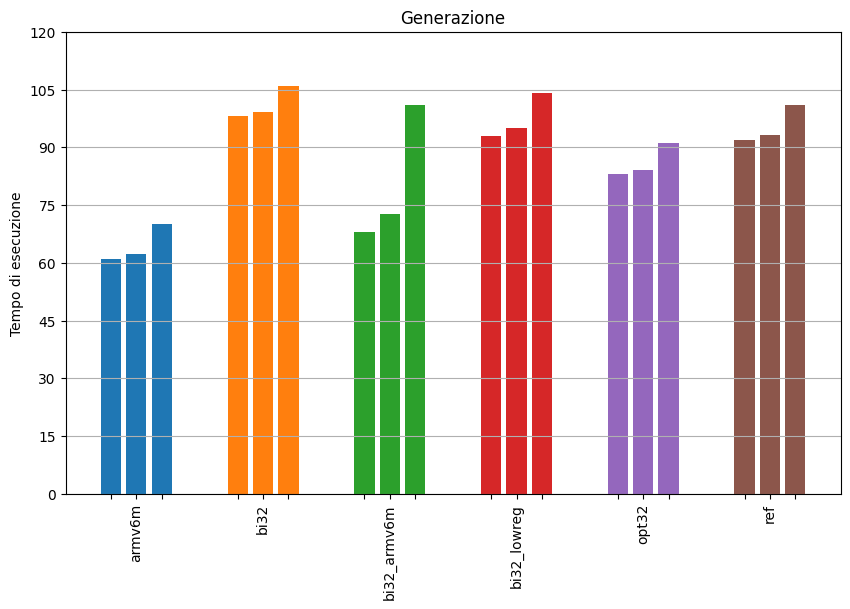

In [5]:
# Generazione tag
plotter(DATAFRAMES, "0B-A", IMPLEMENTATIONS, 15)

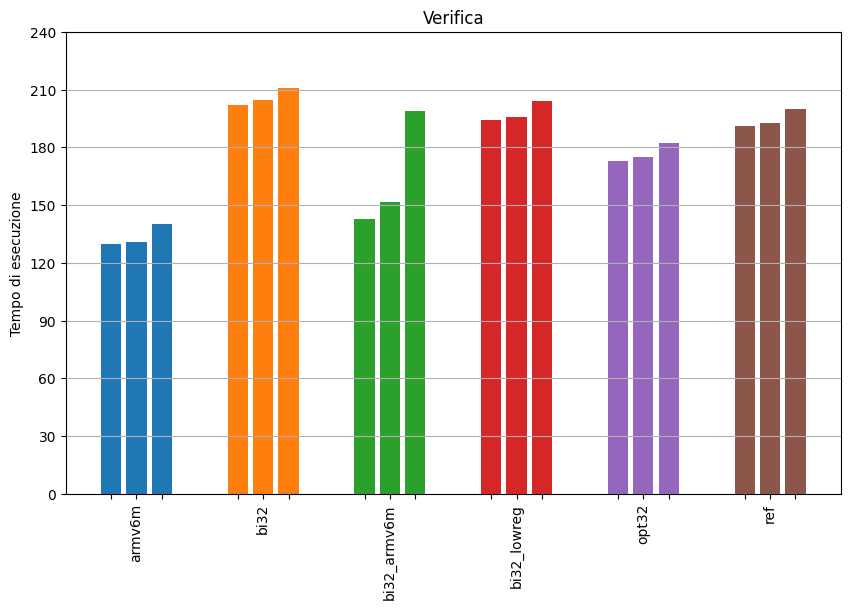

In [6]:
# Verifica tag
plotter(DATAFRAMES, "0B-V", IMPLEMENTATIONS, 30)

### PT 8 byte

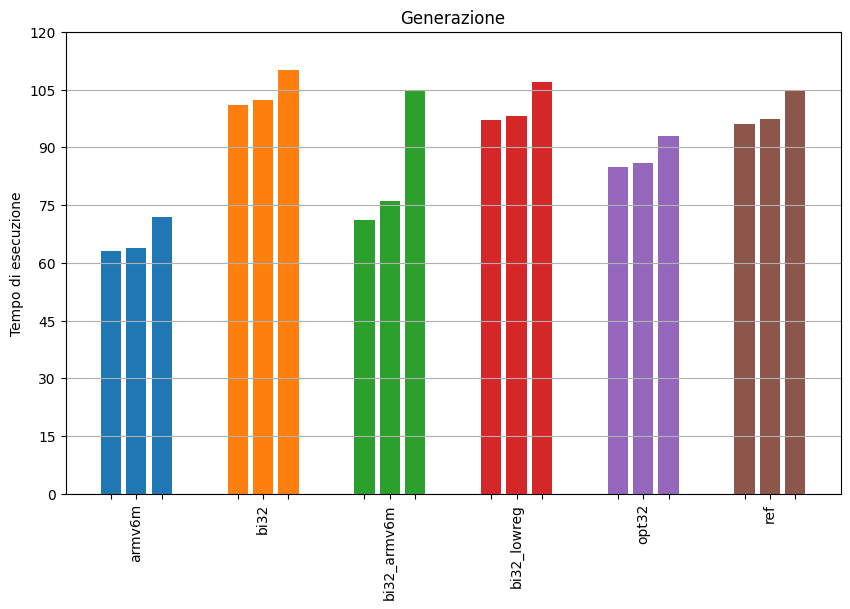

In [7]:
# Generazione tag
plotter(DATAFRAMES, "8B-A", IMPLEMENTATIONS, 15)

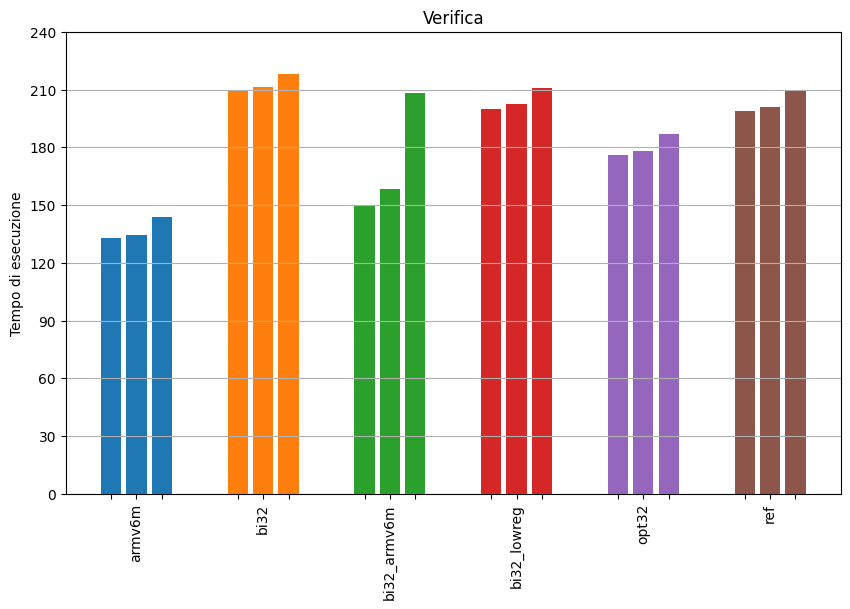

In [8]:
# Verifica tag
plotter(DATAFRAMES, "8B-V", IMPLEMENTATIONS, 30)

### PT 16 byte

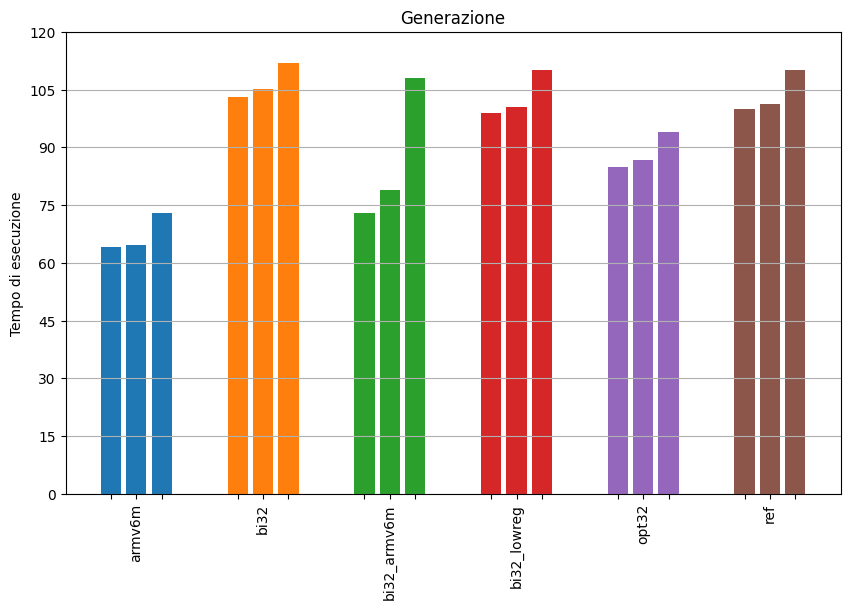

In [9]:
# Generazione tag
plotter(DATAFRAMES, "16B-A", IMPLEMENTATIONS, 15)

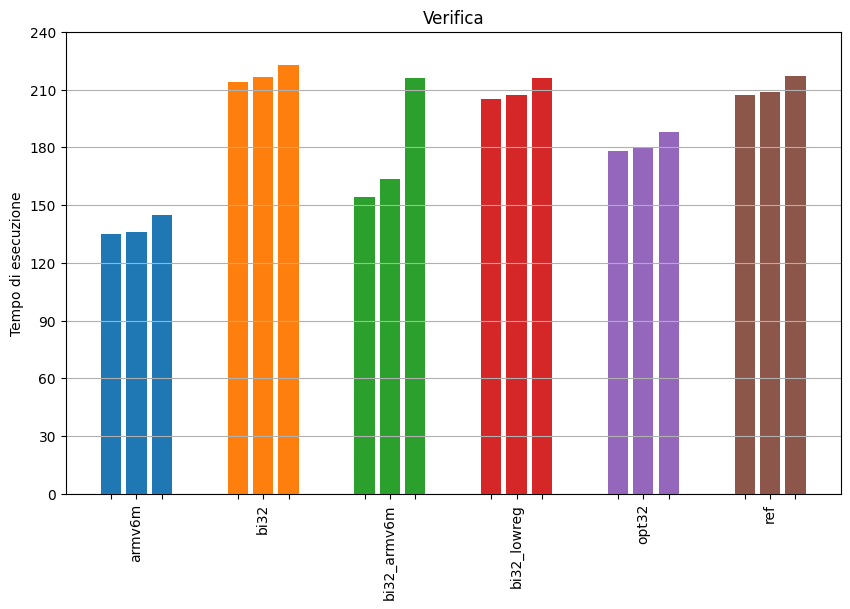

In [10]:
# Verifica tag
plotter(DATAFRAMES, "16B-V", IMPLEMENTATIONS, 30)

## Conclusioni

### Setup

In [11]:
def checker(dataframes: list, columns: list, index: int, check: FunctionType) -> None:
    for column in columns:
        test_series = dataframes[index][column]
        for i in range(len(dataframes)):
            if i == index:
                continue
            series = dataframes[i][column]
            assert check(test_series.min(), series.min())
            assert check(test_series.mean(), series.mean())
            assert check(test_series.max(), series.max())

    print("Nessuna AssertionError è stata sollevata")

In [12]:
def template(best: pd.DataFrame, worst: pd.DataFrame, columns: list, calculate: FunctionType) -> None:
    results = [[], [], []]
    for column in columns:
        best_series = best[column]
        worst_series = worst[column]
        results[0].append(calculate(best_series.min(), worst_series.min()))
        results[1].append(calculate(best_series.mean(), worst_series.mean()))
        results[2].append(calculate(best_series.max(), worst_series.max()))
    
    results = [
        [min(results[0]), max(results[0])],
        [min(results[1]), max(results[1])],
        [min(results[2]), max(results[2])]
    ]

    print(f"Rispetto alla misurazione minima: da {results[0][0]} a {results[0][1]}")
    print(f"Rispetto alla misurazione media: da {results[1][0]} a {results[1][1]}")
    print(f"Rispetto alla misurazione massima: da {results[2][0]} a {results[2][1]}")

In [13]:
def times(best: pd.DataFrame, worst: pd.DataFrame, columns: list) -> None:
    def calculate(best: int, worst: int) -> float:
        return np.around( worst/best, 2 )
    template(best, worst, columns, calculate)
    
    
def percentage_increase(best: pd.DataFrame, worst: pd.DataFrame, columns: list) -> None:
    def calculate(best: int, worst: int) -> float:
        return np.around( ((worst * 100) / best) - 100, 2 )
    template(best, worst, columns, calculate)

### Migliori implementazioni

L'implementazione che ha ottenuto i tempi di esecuzione migliori in ogni possibile grandezza di PT considerata è la `armv6m`, seguita dalle implementazioni `bi32_armv6m` e `opt32`, anche se la seconda classificata ha il tempo massimo che si classifica tra i peggiori possibili

Notiamo come le due migliori implementazioni sono ottimizzate per architetture ARMv6-M, mentre la terza è ottimizzata per architetture $32$ bit generiche

In [14]:
# Armv6m migliore implementazione
for i in range(0,len(INDEX),2):
    try:
        checker(DATAFRAMES, INDEX[i:i+2], 0, lambda x,y : x < y)
    except AssertionError:
        print(f"Armv6m non domina per {INDEX[i]} e {INDEX[i+1]}")
    print()

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata



In [15]:
# Minima e massima varianza bi32_armv6m
values = [bi32_armv6m[column].var() for column in INDEX]
print(min(values), max(values))

79.4293316247265 365.8427813163482


### Peggiori implementazioni

L'implementazione che ha ottenuto i tempi di esecuzione peggiori in ogni possibile grandezza di PT considerata è la `bi32`; volendo quantizzare il peggioramento percentuale rispetto alla implementazione migliore, la `bi32` risulta essere più lenta almeno del $50$\%, arrivando nel caso peggiore fino al $63$\%

Considerando PT di grandezza $0$ e $8$ byte, seguono alla `bi32` le implementazioni `bi32_lowreg` e `ref`, che invertono la loro posizione quando si considerano PT di grandezza $16$ byte

Come detto in precedenza, l'implementazione `bi32_armv6m` ha un tempo massimo molto simile ai tempi massimi di queste implementazioni peggiori

Notiamo come le implementazioni peggiori sono quelle ottimizzate per architetture $32$ bit generiche (`bi32` e `bi32_lowreg`) e quella priva di ottimizzazioni (`ref`)

In [16]:
# Bi32 peggiore implementazione
for i in range(0,len(INDEX),2):
    try:
        checker(DATAFRAMES, INDEX[i:i+2], 1, lambda x,y : x > y)
    except AssertionError:
        print(f"Bi32 non domina per {INDEX[i]} e {INDEX[i+1]}")
    print()

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata



In [17]:
# Bi32 quanti punti percentuali è peggio di armv6m, migliore
percentage_increase(armv6m, bi32, INDEX)

Rispetto alla misurazione minima: da 55.38 a 60.94
Rispetto alla misurazione media: da 56.12 a 62.51
Rispetto alla misurazione massima: da 50.71 a 53.79


### Dimensioni eseguibile

L'implementazione `armv6m`, oltre ad essere la migliore nei tempi di esecuzione, si conferma la migliore anche nelle dimensioni dell'eseguibile, occupando circa il $6/7$\% dello spazio disponibile

Troviamo poi le implementazioni `bi32_armv6m` e `bi32_lowreg`, che occupano leggermente di più della `armv6m` ma rimangono comunque sui $6/7$ punti percentuali

Le due implementazioni peggiori sono `ref` e `opt32`, che occupano circa il $13/14$\% dello spazio disponibile